<div style="text-align: center; color: #6699CC; font-size: 35px; font-weight: bold;">
    PROYECTO DE GRADO 202420. DESPACHO ÓPTIMO INDUSTRIAL CON ELECTROLIZADOR
</div>

<div style="text-align: center; color: #6699CC; font-size: 25px; font-weight: bold;">
    Ing. Alejandro Jesús Salas Durán
</div>

<div style="text-align: center; color: #99CCFF; font-size: 30px; font-weight: bold;">
    Caso III. Venta de Hidrógeno Internacional
</div>


<div style="text-align: center; font-size: 25px; font-weight: bold;">
    Librerías
</div>

In [1]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy_financial as npf
from gurobipy import GRB
import gurobipy as gp
import pandas as pd
import numpy as np
import os

<div style="text-align: center; font-size: 25px; font-weight: bold;">
    Modelo I. Industria 1 con PV, BESS y Electrolizador
</div>

In [2]:
# Valores de PRECIO_H2 para el análisis de sensibilidad
PRECIO_H2_values = [2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10]

# Diccionario para almacenar los resultados de cada iteración
results = {}

for PRECIO_H2 in PRECIO_H2_values:
    print(f"\nEjecutando el modelo para PRECIO_H2 = {PRECIO_H2} $/kg")

    # Parámetros
    T = 48  # Pasos de tiempo (cada 0.5 horas)
    P_max_pv = 220  # Potencia máxima fotovoltaica (kW)
    P_max_L = 110  # Demanda industrial máxima (kW)
    P_max = 110  # Potencia contratada (kW)
    C = 355  # Capacidad de la batería (kWh)
    kappa = 36  # Cargo por demanda ($/kW)
    eta_c = 0.95  # Eficiencia de carga de la batería
    eta_d = 0.92  # Eficiencia de descarga de la batería
    SoC_0 = 177.5  # Estado inicial de carga (50% de la capacidad)
    ny = 12  # Pagos mensuales de potencia pico
    psi_t = 0.05  # Costo adicional por kWh al comprar de la red
    delta_t = 0.5  # Duración de cada paso de tiempo en horas
    CR_c = 0.3     # Tasa máxima de carga de la batería
    CR_d = 0.2     # Tasa máxima de descarga de la batería

    # Parámetros del electrolizador
    EFI_H2 = 50           # kWh/kg de hidrógeno producido
    EFI_H2O = 0.015       # m³/kg de agua
    PRECIO_H2O = 5        # $/m³ de agua
    #PRECIO_H2 = 9         # $/kg de hidrógeno vendido
    S_H2 = 90          # kW, capacidad del electrolizador
    FP_H2 = 1             # Factor de potencia, asumiendo potencia puramente activa
    P_H2 = S_H2 * FP_H2   # kW, consumo de potencia en modo de producción
    P_H2_sb = P_H2 * 0.05 # kW, consumo de potencia en modo espera
    P_H2_idle = P_H2 * 0.005  # kW, consumo de potencia en modo inactivo
    TT_I2P = 1 / 4        # Horas, tiempo para pasar de inactivo a producción (15 minutos)
    TT_S2P = 1 / 60       # Horas, tiempo para pasar de espera a producción (1 minuto)
    STARTS_ALLOWED = 4000 / 365  # Máximo de arranques permitidos por día
    MIN_PL = 0.15         # Carga parcial mínima (15%)

    # Capacidad máxima de producción de hidrógeno en kg/2día
    PROD_H2_max = (S_H2 * T) / EFI_H2  # kg/2día

    # Datos de precio y demanda
    lambda_t = [0.0740, 0.0722, 0.0768, 0.0771, 0.0798, 0.0810, 0.0965, 0.1168, 0.1211, 0.1080,
                0.1010, 0.0872, 0.0968, 0.0846, 0.0988, 0.0884, 0.1161, 0.0946, 0.0937, 0.0969,
                0.1026, 0.0968, 0.1006, 0.0846, 0.0769, 0.0769, 0.0828, 0.0825, 0.0844, 0.0816,
                0.1038, 0.1095, 0.1170, 0.1028, 0.1057, 0.0854, 0.0902, 0.0877, 0.0942, 0.0878,
      
                0.1207, 0.0900, 0.0985, 0.0937, 0.0993, 0.0971, 0.1018, 0.0817]
    P_u_L = [0.6800, 0.7000, 0.6800, 0.6800, 0.6800, 0.7200, 0.8500, 0.9000, 0.9700, 0.9700,
            0.9700, 0.9900, 0.9800, 0.9100, 0.8900, 0.9500, 0.9400, 1.0000, 0.9500, 0.9400,
            0.8100, 0.7700, 0.7600, 0.7100, 0.6700, 0.7000, 0.6800, 0.6700, 0.6800, 0.7200,
            0.8500, 0.8900, 0.9700, 0.9600, 0.9700, 1.0000, 0.9800, 0.9200, 0.9000, 0.9500,
            0.9400, 1.0000, 0.9500, 0.9300, 0.8100, 0.7600, 0.7500, 0.7100]
    P_u_pv = [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0556, 0.1667, 0.3333, 0.5556,
            0.7778, 0.8889, 1.0000, 0.8889, 0.7778, 0.5556, 0.3333, 0.1667, 0.0556, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0556, 0.1667, 0.3333, 0.5556, 0.7778, 0.8889, 1.0000, 0.8889, 0.7778, 0.5556,
            0.3333, 0.1667, 0.0556, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]

    # Modelo
    m = gp.Model("Dispatch_Optimization_With_Electrolyzer")

    # Variables de decisión
    P_c = m.addVars(T, lb=0, name="P_c")  # Potencia de carga de la batería (kW)
    P_d = m.addVars(T, lb=0, name="P_d")  # Potencia de descarga de la batería (kW)
    P_b = m.addVars(T, lb=0, name="P_b")  # Potencia comprada de la red (kW)
    P_s = m.addVars(T, lb=0, name="P_s")  # Potencia vendida a la red (kW)
    SoC = m.addVars(T, lb=0, name="SoC")  # Estado de carga de la batería (kWh)
    w = m.addVars(T, vtype=GRB.BINARY, name="w")  # Indicador de carga
    u = m.addVars(T, vtype=GRB.BINARY, name="u")  # Indicador de compra/venta

    # Variable auxiliar para la potencia máxima comprada de la red
    P_b_max = m.addVar(lb=0, name="P_b_max")

    # Variables de decisión del electrolizador
    a = m.addVars(T, vtype=GRB.BINARY, name="a")  # Estado inactivo
    b = m.addVars(T, vtype=GRB.BINARY, name="b")  # Estado de producción
    c = m.addVars(T, vtype=GRB.BINARY, name="c")  # Estado de espera
    rh = m.addVars(T, lb=0, ub=1, name="rh")      # Nivel de carga al producir (0-1)
    P_E = m.addVars(T, lb=0, name="P_E")          # Potencia consumida por el electrolizador (kW)
    P_E_prod = m.addVars(T, lb=0, name="P_E_prod")  # Potencia durante producción (kW)
    H2_produced = m.addVars(T, lb=0, name="H2_produced")  # Hidrógeno producido en kg
    H2O_consumed = m.addVar(lb=0, name="H2O_consumed") #Agua consumida m^3

    # Variables de ingresos y costos
    C_P = m.addVar(lb=-GRB.INFINITY, name="C_P")       # Costo de producción
    C_St = m.addVar(lb=-GRB.INFINITY, name="C_St")     # Costo en modo standby
    C_idle = m.addVar(lb=-GRB.INFINITY, name="C_idle") # Costo en modo inactivo
    C_I2P = m.addVar(lb=-GRB.INFINITY, name="C_I2P")   # Costo de cambio de inactivo a producción
    C_S2P = m.addVar(lb=-GRB.INFINITY, name="C_S2P")   # Costo de cambio de standby a producción

    # Variable para la producción total de hidrógeno
    Total_H2_produced = m.addVar(lb=0, name="Total_H2_produced")

    # Variables auxiliares para linealización
    d = m.addVars(T, vtype=GRB.BINARY, name="d")  # Para linealizar b[t]*a[t-1]
    e = m.addVars(T, lb=0, ub=1, name="e")        # Para linealizar rh[t]*d[t]
    f = m.addVars(T, vtype=GRB.BINARY, name="f")  # Para linealizar b[t]*c[t-1]
 
    # Función objetivo (modificada)
    m.setObjective(
        -ny * kappa * P_b_max
        + 365/2 * gp.quicksum(lambda_t[t] * P_s[t] - (lambda_t[t] + psi_t) * P_b[t] for t in range(T))
            + 365/2 * (Total_H2_produced * (PRECIO_H2) - PRECIO_H2O * H2O_consumed)
        , GRB.MAXIMIZE)

    # Restricción para la cantidad de agua consumida
    m.addConstr(H2O_consumed == EFI_H2O * Total_H2_produced)

    # Restricciones
    for t in range(T):
        # Balance de potencia
        m.addConstr(
            P_d[t] + P_b[t] + P_u_pv[t] * P_max_pv
            == P_c[t] + P_s[t] + P_u_L[t] * P_max_L + P_E[t]
        )
        # Límites de carga y descarga de la batería
        m.addConstr(P_c[t] <= CR_c * C * w[t])
        m.addConstr(P_d[t] <= CR_d * C * (1 - w[t]))
        # Límites de compra y venta a la red
        m.addConstr(P_b[t] <= P_max * u[t])
        m.addConstr(P_s[t] <= P_max * (1 - u[t]))
        # Potencia máxima del electrolizador
        m.addConstr(P_E[t] <= S_H2)

    # Restricciones para establecer P_b_max como el valor máximo de P_b + P_s
    for t in range(T):
        m.addConstr(P_b_max >= P_b[t] + P_s[t])

    # Restricciones de estado de carga de la batería
    m.addConstr(SoC[0] == SoC_0 + eta_c * P_c[0] - P_d[0] / eta_d)
    for t in range(1, T):
        m.addConstr(
            SoC[t]
            == SoC[t - 1] + eta_c * P_c[t] - P_d[t] / eta_d
        )

    # Límites de SoC
    for t in range(T):
        m.addConstr(0.1 * C <= SoC[t])
        m.addConstr(SoC[t] <= 0.9 * C)

    # Restricciones del electrolizador
    # Condiciones iniciales
    m.addConstr(a[0] == 1)      # Comienza en estado inactivo
    m.addConstr(b[0] == 0)
    m.addConstr(c[0] == 0)
    m.addConstr(rh[0] == 0)     # Sin producción en t=0

    for t in range(T):
        # El electrolizador debe estar en un estado
        m.addConstr(a[t] + b[t] + c[t] == 1)
        # rh[t] solo puede ser positivo cuando está en producción
        m.addConstr(rh[t] <= b[t])
        m.addConstr(rh[t] >= MIN_PL * b[t])
        # Potencia de producción
        m.addConstr(P_E_prod[t] == P_H2 * rh[t])
        # Consumo de potencia del electrolizador
        m.addConstr(P_E[t] == P_E_prod[t] * b[t] + P_H2_sb * c[t] + P_H2_idle * a[t])
        # Producción de hidrógeno
        m.addConstr(H2_produced[t] == (P_E_prod[t] * b[t]) / EFI_H2)

    # Límite en la producción total de hidrógeno
    m.addConstr(Total_H2_produced == gp.quicksum(H2_produced[t] for t in range(T)))
    m.addConstr(Total_H2_produced <= PROD_H2_max)

    # Incluir t = -1 para a y c
    a_vals = { -1: 0 }  # Valor de a en t=-1 es 0
    c_vals = { -1: 0 }  # Valor de c en t=-1 es 0
    a_vals.update({ t: a[t] for t in range(T) })  # Actualizar a_vals con valores de a[t]
    c_vals.update({ t: c[t] for t in range(T) })  # Actualizar c_vals con valores de c[t]

    # Límite de arranques permitidos
    m.addConstr(gp.quicksum(b[t] * a_vals[t-1] for t in range(1, T)) <= STARTS_ALLOWED)

    for t in range(1, T):
        m.addConstr(c[t] * a_vals[t-1] == 0)  # No puede pasar de inactivo a standby directamente

    for t in range(1, T):
        m.addConstr(c_vals[t-1] * a[t] == 0)  # No puede pasar de standby a inactivo directamente

    # Restricciones para d[t] y e[t]
    for t in range(1, T):
        # Linearización de d[t] = b[t] * a[t-1]
        m.addConstr(d[t] <= b[t])
        m.addConstr(d[t] <= a_vals[t-1])
        m.addConstr(d[t] >= b[t] + a_vals[t-1] - 1)
        # Linearización de e[t] = rh[t] * d[t] (restricción cuadrática)
        m.addConstr(e[t] == rh[t] * d[t])  # Restricción cuadrática

    # Restricciones para f[t] = b[t] * c[t-1]
    for t in range(1, T):
        m.addConstr(f[t] <= b[t])
        m.addConstr(f[t] <= c_vals[t-1])
        m.addConstr(f[t] >= b[t] + c_vals[t-1] - 1)
    
    m.addConstr(C_P == gp.quicksum(
    (P_H2 * lambda_t[t] + (P_H2 / EFI_H2) * EFI_H2O * PRECIO_H2O) * rh[t] * b[t]
    for t in range(T)))

    m.addConstr(C_St == gp.quicksum(P_H2_sb * lambda_t[t] * c[t] for t in range(T)))

    m.addConstr(C_idle == gp.quicksum(P_H2_idle * lambda_t[t] * a[t] for t in range(T)))

    m.addConstr(C_I2P == TT_I2P * PRECIO_H2 * (P_H2 / EFI_H2) * gp.quicksum(e[t] for t in range(1, T)))
    m.addConstr(C_S2P == TT_S2P * PRECIO_H2 * (P_H2 / EFI_H2) * gp.quicksum(f[t] for t in range(1, T)))

    # Optimizar
    m.optimize()
    
    # Almacenar resultados
    if m.status == GRB.OPTIMAL:
        results[PRECIO_H2] = {
            'OPEX': C_P.X + C_St.X + C_idle.X + C_I2P.X + C_S2P.X + PRECIO_H2O*H2O_consumed.X,
            'fn': m.ObjVal,
            'P_b_max': P_b_max.X,
            'Total_H2_produced': Total_H2_produced.X,
            'P_c': [P_c[t].X for t in range(T)],
            'P_d': [P_d[t].X for t in range(T)],
            'SoC': [SoC[t].X for t in range(T)],
            'P_b': [P_b[t].X for t in range(T)],
            'P_s': [P_s[t].X for t in range(T)],
            'P_E': [P_E[t].X for t in range(T)],
            'H2_produced': [H2_produced[t].X for t in range(T)],
            'a': [a[t].X for t in range(T)],
            'b': [b[t].X for t in range(T)],
            'c': [c[t].X for t in range(T)],
            'rh': [rh[t].X for t in range(T)],
        }
        # Imprimir resultados
        print("\nResultados:")
        print(f"PRECIO_H2: {PRECIO_H2} $/kg")
        print(f"Potencia máxima comprada de la red (P_b_max): {P_b_max.X:.2f} kW")
        print(f"Producción total de hidrógeno: {Total_H2_produced.X:.2f} kg")
        print(f"Costo de producción del electrolizador: {365/2 * C_P.X:.2f} $")
        print(f"Costo en modo standby: {365/2 * C_St.X:.2f} $")
        print(f"Costo en modo inactivo: {365/2 * C_idle.X:.2f} $")
        print(f"Costo de cambio de inactivo a producción: {365/2 * C_I2P.X:.2f} $")
        print(f"Costo de cambio de standby a producción: {365/2 * C_S2P.X:.2f} $")
        print(f"Costo de agua: {365/2 * PRECIO_H2O*H2O_consumed.X:.2f} $")
    else:
        print(f"No se encontró solución óptima para PRECIO_H2 = {PRECIO_H2}")



Ejecutando el modelo para PRECIO_H2 = 2 $/kg
Set parameter Username


Set parameter LicenseID to value 2595606
Academic license - for non-commercial use only - expires 2025-12-04
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11+.0 (27774.2))

CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 965 rows, 824 columns and 2443 nonzeros
Model fingerprint: 0xcce314ca
Model has 239 quadratic constraints
Variable types: 488 continuous, 336 integer (336 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+02]
  QMatrix range    [2e-02, 1e+01]
  QLMatrix range   [5e-01, 5e+00]
  Objective range  [1e+01, 9e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
  QRHS range       [1e+01, 1e+01]
Presolve removed 458 rows and 314 columns
Presolve time: 0.01s
Presolved: 739 rows, 602 columns, 1985 nonzeros
Variable types: 349 continuous, 253 integer (253 binary)
Found heuristic solution: obje

<div style="text-align: center; font-size: 25px; font-weight: bold;">
    Gráficas de Potencias y Estados
</div>

In [3]:
# Generar una imagen por cada PRECIO_H2
for PRECIO_H2 in PRECIO_H2_values:
    if PRECIO_H2 in results:
        res = results[PRECIO_H2]
        time = np.arange(1, 49)  # Eje temporal

        # Crear figura con GridSpec
        fig = plt.figure(figsize=(15, 15))
        gs = gridspec.GridSpec(3, 2, figure=fig)  # 3x2 rejilla

        fig.suptitle(f"Resultados para $H_2 = {PRECIO_H2} $/kg", fontsize=16)

        # Potencia comprada y vendida
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.plot(time, res['P_b'], label='P_b (Potencia comprada)')
        ax1.plot(time, res['P_s'], label='P_s (Potencia vendida)')
        ax1.set_title("Potencia comprada y vendida")
        ax1.set_xlabel("Tiempo (t)")
        ax1.set_ylabel("Potencia (kW)")
        ax1.legend()
        ax1.grid()

        # Potencia de carga, descarga y PV
        ax2 = fig.add_subplot(gs[0, 1])
        ax2.plot(time, res['P_c'], label='P_c (Potencia de carga)')
        ax2.plot(time, res['P_d'], label='P_d (Potencia de descarga)')

        # Agregar la curva del parque PV
        P_pv = np.array(P_u_pv) * P_max_pv  # Calcular la potencia del parque PV
        ax2.plot(time, P_pv, label='P_pv (Potencia PV)', color='green', linestyle='--')

        ax2.set_title("Potencia de carga, descarga y parque PV")
        ax2.set_xlabel("Tiempo (t)")
        ax2.set_ylabel("Potencia (kW)")
        ax2.legend()
        ax2.grid()

        # Estado de carga de la batería
        ax3 = fig.add_subplot(gs[1, 0])
        ax3.plot(time, res['SoC'], label='SoC (Estado de carga)')
        ax3.set_title("Estado de carga de la batería")
        ax3.set_xlabel("Tiempo (t)")
        ax3.set_ylabel("Energía (kWh)")
        ax3.legend()
        ax3.grid()

        # Estado del electrolizador
        ax4 = fig.add_subplot(gs[1, 1])
        ax4.plot(time, res['a'], label='a (Inactivo)')
        ax4.plot(time, res['b'], label='b (Producción)')
        ax4.plot(time, res['c'], label='c (Espera)')
        ax4.set_title("Estado del electrolizador")
        ax4.set_xlabel("Tiempo (t)")
        ax4.set_ylabel("Estado")
        ax4.legend()
        ax4.grid()

        # Nivel de carga del electrolizador (centrado en la fila inferior)
        ax5 = fig.add_subplot(gs[2, :])  # Ocupa toda la fila inferior
        ax5.plot(time, res['rh'], label='rh (Nivel de carga)', color="orange")
        ax5.set_title("Nivel de carga del electrolizador")
        ax5.set_xlabel("Tiempo (t)")
        ax5.set_ylabel("Nivel de carga")
        ax5.legend()
        ax5.grid()

        # Guardar figura
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.savefig(f"C3_PrecioH2_{PRECIO_H2}.png")
        plt.close()

# Mostrar nombres de archivos generados
generated_files = [f for f in os.listdir() if f.startswith("Resultados_PrecioH2_") and f.endswith(".png")]
generated_files


[]

<div style="text-align: center; font-size: 25px; font-weight: bold;">
    Modelo II. Industria 1 con PV y BESS
</div>

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11+.0 (27774.2))

CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 480 rows, 337 columns and 1151 nonzeros
Model fingerprint: 0x88abe909
Variable types: 241 continuous, 96 integer (96 binary)
Coefficient statistics:
  Matrix range     [9e-01, 1e+02]
  Objective range  [1e+01, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+01, 3e+02]
Found heuristic solution: objective -94029.42608
Presolve removed 239 rows and 95 columns
Presolve time: 0.00s
Presolved: 241 rows, 242 columns, 663 nonzeros
Variable types: 178 continuous, 64 integer (64 binary)

Root relaxation: objective -6.917844e+04, 104 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Nod

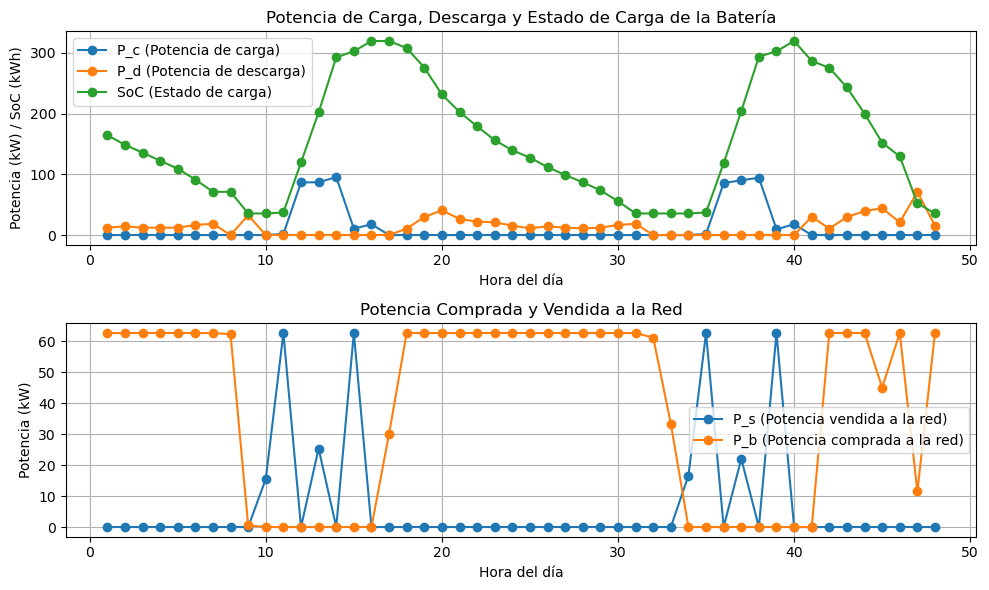

0


In [4]:
"""
@author: Paulo M. De Oliveira
"""

# Parameters
T = 48  # Time steps
P_max_pv = 220  # Max power of photovoltaic
P_max_L = 110  # Max industrial demand
P_max = 110  # Contracted power
C = 355  # Battery capacity
kappa = 36  # Demand charge
eta_c = 0.95  # Battery charging efficiency
eta_d = 0.92  # Battery discharging efficiency
SoC_0= 177.5  # Final state of charge
ny=12 #monthy peak power payments
# Price and demand data (example)
lambda_t = [0.0740, 0.0722, 0.0768, 0.0771, 0.0798, 0.0810, 0.0965, 0.1168, 0.1211, 0.1080,
           0.1010, 0.0872, 0.0968, 0.0846, 0.0988, 0.0884, 0.1161, 0.0946, 0.0937, 0.0969,
           0.1026, 0.0968, 0.1006, 0.0846, 0.0769, 0.0769, 0.0828, 0.0825, 0.0844, 0.0816,
           0.1038, 0.1095, 0.1170, 0.1028, 0.1057, 0.0854, 0.0902, 0.0877, 0.0942, 0.0878,
           0.1207, 0.0900, 0.0985, 0.0937, 0.0993, 0.0971, 0.1018, 0.0817]
P_u_L =[0.6800, 0.7000, 0.6800, 0.6800, 0.6800, 0.7200, 0.8500, 0.9000, 0.9700, 0.9700,
         0.9700, 0.9900, 0.9800, 0.9100, 0.8900, 0.9500, 0.9400, 1.0000, 0.9500, 0.9400,
         0.8100, 0.7700, 0.7600, 0.7100, 0.6700, 0.7000, 0.6800, 0.6700, 0.6800, 0.7200,
         0.8500, 0.8900, 0.9700, 0.9600, 0.9700, 1.0000, 0.9800, 0.9200, 0.9000, 0.9500,
         0.9400, 1.0000, 0.9500, 0.9300, 0.8100, 0.7600, 0.7500, 0.7100]
P_u_L_2 = [0.9400, 0.9500, 0.9200, 0.9200, 0.9800, 1.0000, 1.0000, 0.9600, 0.9100, 0.8200,
         0.7300, 0.6300, 0.6700, 0.6300, 0.5900, 0.5900, 0.5800, 0.5900, 0.7300, 0.8500,
         0.9500, 0.9500, 0.9600, 0.9400, 0.9400, 0.9400, 0.9200, 0.9200, 0.9900, 0.9900,
         1.0000, 0.9500, 0.9000, 0.8300, 0.7300, 0.6300, 0.6600, 0.6200, 0.6000, 0.5800,
         0.5800, 0.6000, 0.7400, 0.8500, 0.9500, 0.9500, 0.9600, 0.9400]
P_u_pv = [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0556, 0.1667, 0.3333, 0.5556,
         0.7778, 0.8889, 1.0000, 0.8889, 0.7778, 0.5556, 0.3333, 0.1667, 0.0556, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0556, 0.1667, 0.3333, 0.5556, 0.7778, 0.8889, 1.0000, 0.8889, 0.7778, 0.5556,
         0.3333, 0.1667, 0.0556, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]
psi_t = 0.05

# Model
m = gp.Model("Dispatch_Optimization")

# Decision variables
P_c = m.addVars(T, lb=0, name="P_c")  # Charging power
P_d = m.addVars(T, lb=0, name="P_d")  # Discharging power
P_b = m.addVars(T, lb=0, name="P_b")  # Power bought from grid
P_s = m.addVars(T, lb=0, name="P_s")  # Power sold to grid
SoC = m.addVars(T, lb=0, name="SoC")  # State of charge
w = m.addVars(T, vtype=GRB.BINARY, name="w")  # Charging indicator
u = m.addVars(T, vtype=GRB.BINARY, name="u")  # Power import/export indicator

#Auxiliary variable for the maximum power bought from the grid
P_b_max = m.addVar(lb=0, name="P_b_max")

#Constraints to set P_b_max as the maximum value of P_b
for t in range(T):
    m.addConstr(P_b_max >= P_b[t] + P_s[t])

# Objective function
m.setObjective(
    -ny*kappa * P_b_max + 365/2 * gp.quicksum(lambda_t[t] * P_s[t] - (lambda_t[t] + psi_t) * P_b[t] for t in range(T)),
    GRB.MAXIMIZE
)

# Constraints
for t in range(T):
    m.addConstr(P_d[t] + P_b[t] + P_u_pv[t] * P_max_pv == P_c[t] + P_s[t] + P_u_L[t] * P_max_L)
    m.addConstr(P_c[t] <= 0.3 * C * w[t])
    m.addConstr(P_d[t] <= 0.2 * C * (1 - w[t]))
    m.addConstr(P_b[t] <= P_max * u[t])
    m.addConstr(P_s[t] <= P_max * (1 - u[t]))

# State of charge constraints
m.addConstr(SoC[0] == SoC_0 + P_c[0]*eta_c - P_d[0]/eta_d)  # Initial state of charge
for t in range(1, T):
    m.addConstr(SoC[t] == SoC[t-1] + eta_c * P_c[t] - P_d[t] / eta_d)

# Battery limits
for t in range(T):
    m.addConstr(0.1 * C <= SoC[t])
    m.addConstr(SoC[t] <= 0.9 * C)
    m.addConstr(P_b_max >= P_b[t] + P_s[t])

# Optimize
m.optimize()

pv_BESS = m.ObjVal

# Verificar si la optimización fue exitosa
if m.status == GRB.OPTIMAL:
    # Crear diccionarios para almacenar los resultados de las variables
    P_c_sol = {t: P_c[t].x for t in range(T)}  # Potencia de carga
    P_d_sol = {t: P_d[t].x for t in range(T)}  # Potencia de descarga
    P_b_sol = {t: P_b[t].x for t in range(T)}  # Potencia comprada a la red
    P_s_sol = {t: P_s[t].x for t in range(T)}  # Potencia vendida a la red
    SoC_sol = {t: SoC[t].x for t in range(T)}  # Estado de carga de la batería
    P_b_max_sol = P_b_max.x 
   
else:
    print("No se encontró una solución óptima.")
    
import matplotlib.pyplot as plt

# Plot P_c_sol, P_d_sol, and SoC_sol
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(range(1, T+1), [P_c_sol[t] for t in range(T)], label='P_c (Potencia de carga)', marker='o')
plt.plot(range(1, T+1), [P_d_sol[t] for t in range(T)], label='P_d (Potencia de descarga)', marker='o')
plt.plot(range(1, T+1), [SoC_sol[t] for t in range(T)], label='SoC (Estado de carga)', marker='o')

plt.title('Potencia de Carga, Descarga y Estado de Carga de la Batería')
plt.xlabel('Hora del día')
plt.ylabel('Potencia (kW) / SoC (kWh)')
plt.legend()
plt.grid(True)

# Plot P_s_sol and P_b_sol
plt.subplot(2, 1, 2)
plt.plot(range(1, T+1), [P_s_sol[t] for t in range(T)], label='P_s (Potencia vendida a la red)', marker='o')
plt.plot(range(1, T+1), [P_b_sol[t] for t in range(T)], label='P_b (Potencia comprada a la red)', marker='o')

plt.title('Potencia Comprada y Vendida a la Red')
plt.xlabel('Hora del día')
plt.ylabel('Potencia (kW)')
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()
print(sum(P_b_sol)-sum(P_s_sol))


<div style="text-align: center; font-size: 25px; font-weight: bold;">
    Análisis Económico. Indicadores Financieros
</div>

82.47000384
14468.421726315788
{2: -700.7088375000021, 2.5: -700.7088375000021, 3: -700.7088375000021, 3.5: -700.7088375000021, 4: -700.7088375000021, 4.5: -697.4227946428468, 5: -494.33239824803655, 5.5: 28.02632684188883, 6: 630.877232105045, 6.5: 1233.728137368201, 7: 2155.8613595163156, 7.5: 3767.6623693345405, 8: 5848.7822285606435, 8.5: 8266.830326558866, 9: 10935.836869094883, 9.5: 13632.863639686751, 10: 16369.77123244571}
82.47000384
14468.421726315788
{2: -700.7088375000021, 2.5: -700.7088375000021, 3: -700.7088375000021, 3.5: -700.7088375000021, 4: -700.7088375000021, 4.5: -697.4227946428468, 5: -494.33239824803655, 5.5: 28.02632684188883, 6: 630.877232105045, 6.5: 1233.728137368201, 7: 2155.8613595163156, 7.5: 3767.6623693345405, 8: 5848.7822285606435, 8.5: 8266.830326558866, 9: 10935.836869094883, 9.5: 13632.863639686751, 10: 16369.77123244571}
82.47000384
14468.421726315788
{2: -700.7088375000021, 2.5: -700.7088375000021, 3: -700.7088375000021, 3.5: -700.7088375000021, 4:

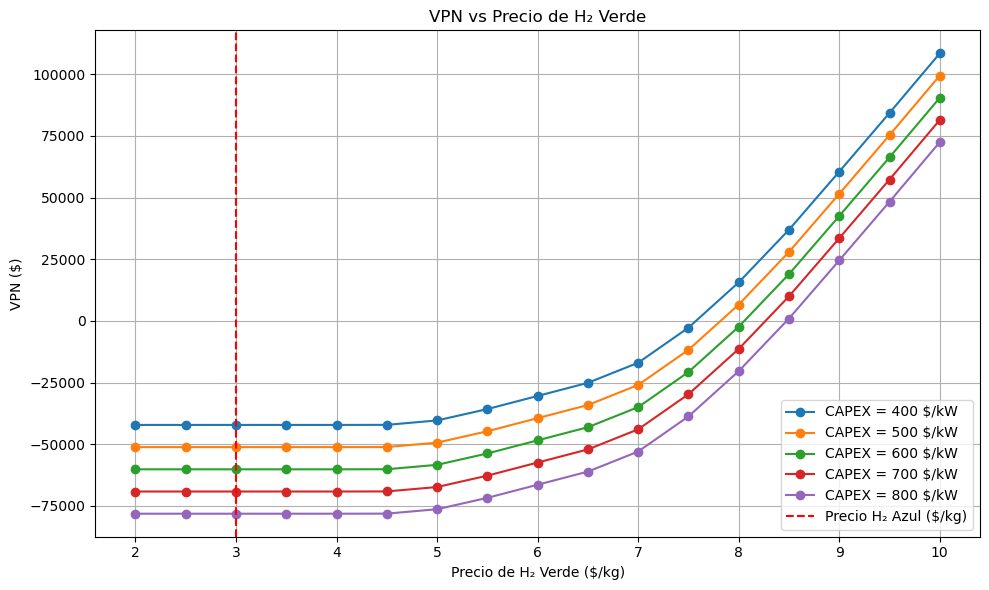

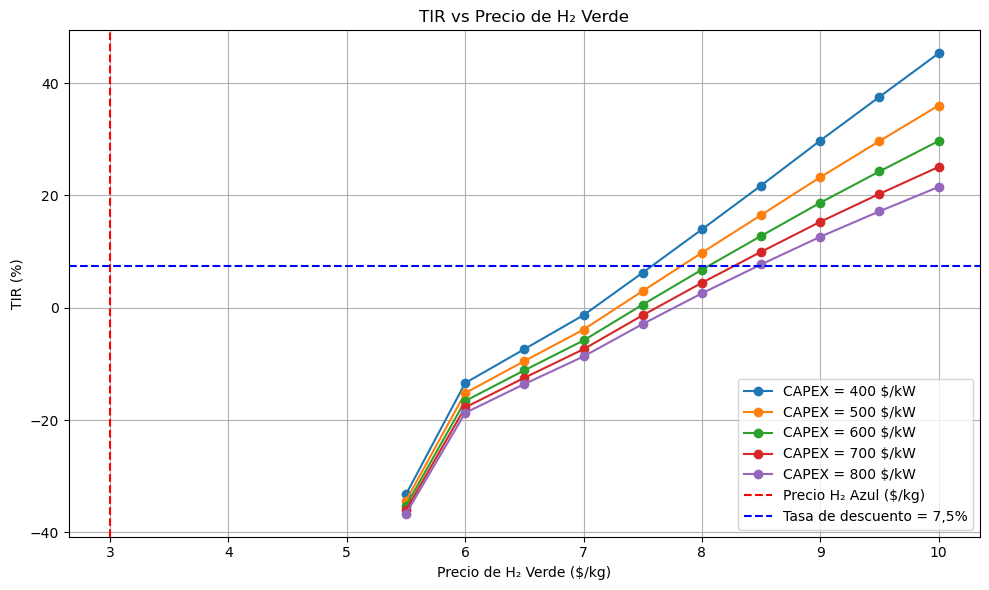

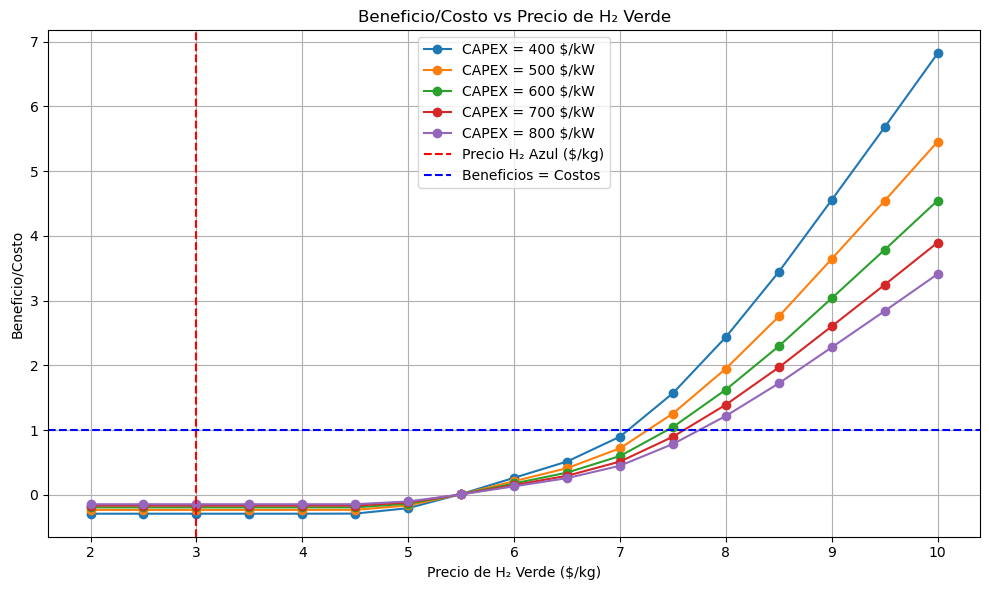

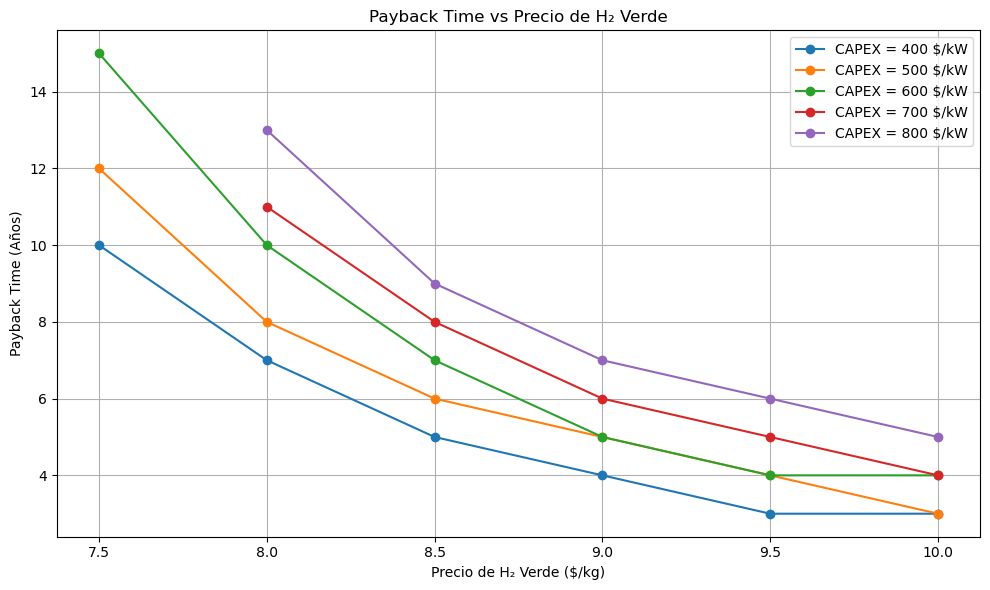

,400,500,600,700,800
2.0,"{'VPN': -42185.240815017976, 'TIR': nan, 'Payb...","{'VPN': -51185.240815017976, 'TIR': nan, 'Payb...","{'VPN': -60185.240815017976, 'TIR': nan, 'Payb...","{'VPN': -69185.24081501797, 'TIR': nan, 'Payba...","{'VPN': -78185.24081501797, 'TIR': nan, 'Payba..."
2.5,"{'VPN': -42185.240815017976, 'TIR': nan, 'Payb...","{'VPN': -51185.240815017976, 'TIR': nan, 'Payb...","{'VPN': -60185.240815017976, 'TIR': nan, 'Payb...","{'VPN': -69185.24081501797, 'TIR': nan, 'Payba...","{'VPN': -78185.24081501797, 'TIR': nan, 'Payba..."
3.0,"{'VPN': -42185.240815017976, 'TIR': nan, 'Payb...","{'VPN': -51185.240815017976, 'TIR': nan, 'Payb...","{'VPN': -60185.240815017976, 'TIR': nan, 'Payb...","{'VPN': -69185.24081501797, 'TIR': nan, 'Payba...","{'VPN': -78185.24081501797, 'TIR': nan, 'Payba..."
3.5,"{'VPN': -42185.240815017976, 'TIR': nan, 'Payb...","{'VPN': -51185.240815017976, 'TIR': nan, 'Payb...","{'VPN': -60185.240815017976, 'TIR': nan, 'Payb...","{'VPN': -69185.24081501797, 'TIR': nan, 'Payba...","{'VPN': -78185.24081501797, 'TIR': nan, 'Payba..."
4.0,"{'VPN': -42185.240815017976, 'TIR': nan, 'Payb...","{'VPN': -51185.240815017976, 'TIR': nan, 'Payb...","{'VPN': -60185.240815017976, 'TIR': nan, 'Payb...","{'VPN': -69185.24081501797, 'TIR': nan, 'Payba...","{'VPN': -78185.24081501797, 'TIR': nan, 'Payba..."
4.5,"{'VPN': -42156.234521230544, 'TIR': nan, 'Payb...","{'VPN': -51156.234521230544, 'TIR': nan, 'Payb...","{'VPN': -60156.234521230544, 'TIR': nan, 'Payb...","{'VPN': -69156.23452123054, 'TIR': nan, 'Payba...","{'VPN': -78156.23452123054, 'TIR': nan, 'Payba..."
5.0,"{'VPN': -40363.531273186585, 'TIR': nan, 'Payb...","{'VPN': -49363.531273186585, 'TIR': nan, 'Payb...","{'VPN': -58363.531273186585, 'TIR': nan, 'Payb...","{'VPN': -67363.53127318659, 'TIR': nan, 'Payba...","{'VPN': -76363.53127318659, 'TIR': nan, 'Payba..."
5.5,"{'VPN': -35752.60825695311, 'TIR': -0.33230042...","{'VPN': -44752.60825695311, 'TIR': -0.34360168...","{'VPN': -53752.60825695311, 'TIR': -0.35263839...","{'VPN': -62752.60825695311, 'TIR': -0.36014626...","{'VPN': -71752.60825695311, 'TIR': -0.36655501..."
6.0,"{'VPN': -30431.171127791462, 'TIR': -0.1339158...","{'VPN': -39431.17112779146, 'TIR': -0.15187452...","{'VPN': -48431.17112779146, 'TIR': -0.16592272...","{'VPN': -57431.17112779146, 'TIR': -0.17740502...","{'VPN': -66431.17112779146, 'TIR': -0.18708190..."
6.5,"{'VPN': -25109.73399862981, 'TIR': -0.07358762...","{'VPN': -34109.73399862981, 'TIR': -0.09487955...","{'VPN': -43109.73399862981, 'TIR': -0.11132012...","{'VPN': -52109.73399862981, 'TIR': -0.12463007...","{'VPN': -61109.73399862981, 'TIR': -0.13576469..."


In [5]:
# Ahorro Anual
kg_CO2_evitados_H2 = 12  # kg_CO2/kg_H2
bono = 0.0057  # $/kg_CO2 -> 5 $/tCO2

# Definir los costos de inversión (CAPEX) diferentes
electrolizador_costs = [400, 500, 600, 700, 800]  # $/kW

# Parámetros
horizonte_tiempo = 15  # Años
tasa_descuento = 0.075  # Tasa de descuento

# Definir funciones de análisis financiero
def calcular_vpn(flujo_caja, tasa_descuento):
    """Calcula el Valor Presente Neto (VPN)"""
    return sum(flujo / (1 + tasa_descuento)**t for t, flujo in enumerate(flujo_caja))

def calcular_tir(flujo_caja):
    """Calcula la Tasa Interna de Retorno (TIR)"""
    return npf.irr(flujo_caja)

def calcular_payback(flujo_caja):
    """Calcula el tiempo de recuperación (Payback Time)"""
    acumulado = 0
    for t, flujo in enumerate(flujo_caja):
        acumulado += flujo
        if acumulado >= 0:
            return t  # Tiempo en años
    return None

def calcular_beneficio_costo(flujo_caja):
    """Calcula la relación Beneficio/Costo"""
    beneficios = sum(flujo for flujo in flujo_caja[1:])
    return beneficios / abs(flujo_caja[0])  # Beneficio/Costo

def calcular_lcoh(CAPEX, OPEX_anual, H2_producido_anual, tasa_descuento, horizonte_tiempo):
    """Calcula el Levelized Cost of Hydrogen (LCOH)"""
    # CAPEX en año 0 (no se descuenta)
    costos = [CAPEX] + [OPEX_anual] * horizonte_tiempo
    # Hidrógeno producido cada año (suponemos constante)
    produccion = [H2_producido_anual] * horizonte_tiempo
    # Valor presente de los costos
    VP_costos = sum(costo / (1 + tasa_descuento)**t for t, costo in enumerate(costos))
    # Valor presente del hidrógeno producido
    VP_produccion = sum(prod / (1 + tasa_descuento)**t for t, prod in enumerate(produccion))
    # Manejar división por cero
    if VP_produccion == 0:
        return float('inf')
    # LCOH
    return VP_costos / VP_produccion

# Crear estructura de datos para almacenar los resultados financieros
resultados_financieros = {}

# Listas para almacenar datos para las gráficas
precios_h2 = sorted(results.keys())
vpn_data = {electrolizador: [] for electrolizador in electrolizador_costs}
tir_data = {electrolizador: [] for electrolizador in electrolizador_costs}
bc_data = {electrolizador: [] for electrolizador in electrolizador_costs}
payback_data = {electrolizador: [] for electrolizador in electrolizador_costs}

# Loop sobre los costos del electrolizador
for electrolizador in electrolizador_costs:
    CAPEX = electrolizador * S_H2  # Calcular CAPEX para el costo actual

    # Calcular el ahorro anual para cada precio de hidrógeno
    ahorro_electrolizador = {}
    for precio_h2 in results:
        ahorro_electrolizador[precio_h2] = results[precio_h2]['fn'] - pv_BESS + \
            365 / 2 * (results[precio_h2]['Total_H2_produced'] * (bono * kg_CO2_evitados_H2))
        if precio_h2 == 6:
            print(365 / 2 * (results[precio_h2]['Total_H2_produced'] * (bono * kg_CO2_evitados_H2)))
            print(365 / 2 * (results[precio_h2]['Total_H2_produced'] *  kg_CO2_evitados_H2))
        OPEX_anual = 365 / 2 * results[precio_h2]['OPEX']
    print(ahorro_electrolizador)
    # Crear flujos de caja para cada precio de hidrógeno
    flujos_caja = {}
    lcoh_values = {}
    for precio_h2, ahorro_anual in ahorro_electrolizador.items():
        # Flujo de caja anual constante (a partir del año 1)
        flujo_anual = [ahorro_anual] * horizonte_tiempo
        # Incluir inversión inicial en el primer año
        flujo_caja = [-CAPEX] + flujo_anual
        flujos_caja[precio_h2] = flujo_caja

        H2_producido_anual = 365 / 2 * results[precio_h2]['Total_H2_produced']

        if H2_producido_anual == 0:
            LCOH = float('inf')  # O algún valor que indique que no es calculable
        else:
            LCOH = calcular_lcoh(CAPEX, OPEX_anual, H2_producido_anual, tasa_descuento, horizonte_tiempo)

        lcoh_values[precio_h2] = LCOH

    # Análisis financiero para cada precio de hidrógeno
    resultados_financieros_electrolizador = {}
    for precio_h2, flujo_caja in flujos_caja.items():
        vpn = calcular_vpn(flujo_caja, tasa_descuento)
        tir = calcular_tir(flujo_caja)
        payback = calcular_payback(flujo_caja)
        b_c = calcular_beneficio_costo(flujo_caja)
        resultados_financieros_electrolizador[precio_h2] = {
            "VPN": vpn,
            "TIR": tir,
            "Payback": payback,
            "B/C": b_c,
            "LCOH": lcoh_values[precio_h2],
            "Flujo de caja": flujo_caja
        }

        # Almacenar datos para las gráficas
        vpn_data[electrolizador].append(vpn)
        tir_data[electrolizador].append(tir * 100)  # Convertir a porcentaje
        bc_data[electrolizador].append(b_c)
        payback_data[electrolizador].append(payback)

    # Guardar los resultados para este electrolizador
    resultados_financieros[electrolizador] = resultados_financieros_electrolizador

# Generar las gráficas para VPN, TIR, B/C y Payback Time
# Línea discontinua fija
precio_h2_azul = 3  # Precio del H₂ Azul en $/kg

# VPN
plt.figure(figsize=(10, 6))
for electrolizador in electrolizador_costs:
    plt.plot(precios_h2, vpn_data[electrolizador], marker='o', label=f'CAPEX = {electrolizador} $/kW')
plt.axvline(precio_h2_azul, color='red', linestyle='--', label='Precio H₂ Azul ($/kg)')
plt.title("VPN vs Precio de H₂ Verde")
plt.xlabel("Precio de H₂ Verde ($/kg)")
plt.ylabel("VPN ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# TIR
plt.figure(figsize=(10, 6))
for electrolizador in electrolizador_costs:
    plt.plot(precios_h2, tir_data[electrolizador], marker='o', label=f'CAPEX = {electrolizador} $/kW')
plt.axvline(precio_h2_azul, color='red', linestyle='--', label='Precio H₂ Azul ($/kg)')
plt.axhline(tasa_descuento*100, color='blue', linestyle='--', label='Tasa de descuento = 7,5%')
plt.title("TIR vs Precio de H₂ Verde")
plt.xlabel("Precio de H₂ Verde ($/kg)")
plt.ylabel("TIR (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# B/C
plt.figure(figsize=(10, 6))
for electrolizador in electrolizador_costs:
    plt.plot(precios_h2, bc_data[electrolizador], marker='o', label=f'CAPEX = {electrolizador} $/kW')
plt.axvline(precio_h2_azul, color='red', linestyle='--', label='Precio H₂ Azul ($/kg)')
plt.axhline(1, color='blue', linestyle='--', label='Beneficios = Costos')
plt.title("Beneficio/Costo vs Precio de H₂ Verde")
plt.xlabel("Precio de H₂ Verde ($/kg)")
plt.ylabel("Beneficio/Costo")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Payback Time
plt.figure(figsize=(10, 6))
for electrolizador in electrolizador_costs:
    plt.plot(precios_h2, payback_data[electrolizador], marker='o', label=f'CAPEX = {electrolizador} $/kW')
plt.title("Payback Time vs Precio de H₂ Verde")
plt.xlabel("Precio de H₂ Verde ($/kg)")
plt.ylabel("Payback Time (Años)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

pd.DataFrame(resultados_financieros)


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11+.0 (27774.2))

CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 240 rows, 337 columns and 576 nonzeros
Model fingerprint: 0x38d79b2a
Variable types: 241 continuous, 96 integer (96 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+01, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e+01, 1e+02]
Found heuristic solution: objective -165971.0319
Presolve removed 240 rows and 337 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 2: -165971 -165971 
No other solutions better than -165971

Optimal solution found (tolerance 1.00e-04)
Best objective -1.659710318750e+05, best bound -1.6597

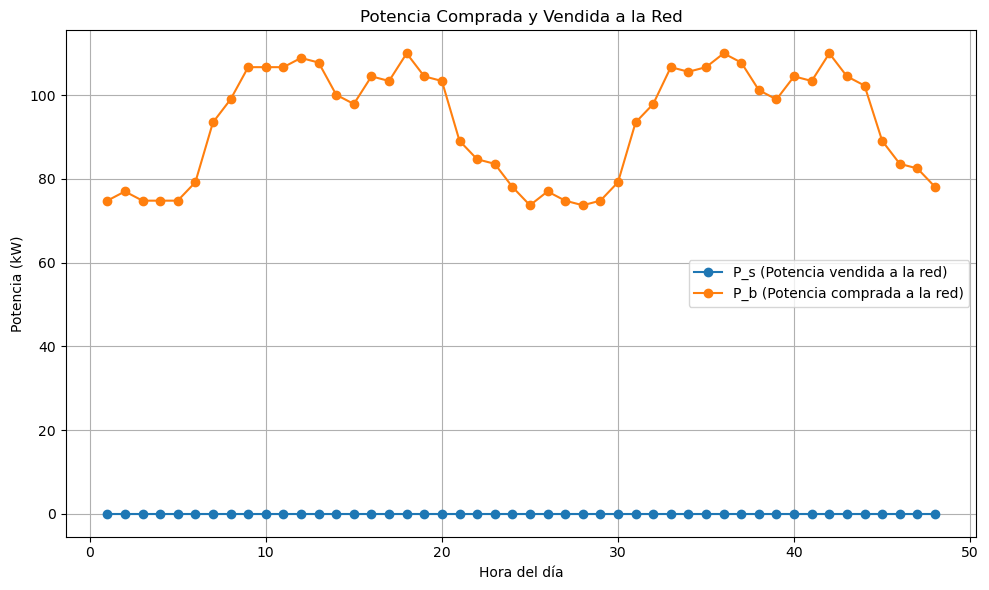

205860.0


In [6]:
# Parameters
T = 48  # Time steps
P_max_pv = 220  # Max power of photovoltaic
P_max_L = 110  # Max industrial demand
P_max = 110  # Contracted power
C = 355  # Battery capacity
kappa = 36  # Demand charge
eta_c = 0.95  # Battery charging efficiency
eta_d = 0.92  # Battery discharging efficiency
SoC_0= 177.5  # Final state of charge
ny=12 #monthy peak power payments
# Price and demand data (example)
lambda_t = [0.0740, 0.0722, 0.0768, 0.0771, 0.0798, 0.0810, 0.0965, 0.1168, 0.1211, 0.1080,
           0.1010, 0.0872, 0.0968, 0.0846, 0.0988, 0.0884, 0.1161, 0.0946, 0.0937, 0.0969,
           0.1026, 0.0968, 0.1006, 0.0846, 0.0769, 0.0769, 0.0828, 0.0825, 0.0844, 0.0816,
           0.1038, 0.1095, 0.1170, 0.1028, 0.1057, 0.0854, 0.0902, 0.0877, 0.0942, 0.0878,
           0.1207, 0.0900, 0.0985, 0.0937, 0.0993, 0.0971, 0.1018, 0.0817]
P_u_L =[0.6800, 0.7000, 0.6800, 0.6800, 0.6800, 0.7200, 0.8500, 0.9000, 0.9700, 0.9700,
         0.9700, 0.9900, 0.9800, 0.9100, 0.8900, 0.9500, 0.9400, 1.0000, 0.9500, 0.9400,
         0.8100, 0.7700, 0.7600, 0.7100, 0.6700, 0.7000, 0.6800, 0.6700, 0.6800, 0.7200,
         0.8500, 0.8900, 0.9700, 0.9600, 0.9700, 1.0000, 0.9800, 0.9200, 0.9000, 0.9500,
         0.9400, 1.0000, 0.9500, 0.9300, 0.8100, 0.7600, 0.7500, 0.7100]
P_u_L_2 = [0.9400, 0.9500, 0.9200, 0.9200, 0.9800, 1.0000, 1.0000, 0.9600, 0.9100, 0.8200,
         0.7300, 0.6300, 0.6700, 0.6300, 0.5900, 0.5900, 0.5800, 0.5900, 0.7300, 0.8500,
         0.9500, 0.9500, 0.9600, 0.9400, 0.9400, 0.9400, 0.9200, 0.9200, 0.9900, 0.9900,
         1.0000, 0.9500, 0.9000, 0.8300, 0.7300, 0.6300, 0.6600, 0.6200, 0.6000, 0.5800,
         0.5800, 0.6000, 0.7400, 0.8500, 0.9500, 0.9500, 0.9600, 0.9400]
P_u_pv = [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0556, 0.1667, 0.3333, 0.5556,
         0.7778, 0.8889, 1.0000, 0.8889, 0.7778, 0.5556, 0.3333, 0.1667, 0.0556, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0556, 0.1667, 0.3333, 0.5556, 0.7778, 0.8889, 1.0000, 0.8889, 0.7778, 0.5556,
         0.3333, 0.1667, 0.0556, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]
psi_t = 0.05

# Model
m = gp.Model("Dispatch_Optimization")

# Decision variables
P_c = m.addVars(T, lb=0, name="P_c")  # Charging power
P_d = m.addVars(T, lb=0, name="P_d")  # Discharging power
P_b = m.addVars(T, lb=0, name="P_b")  # Power bought from grid
P_s = m.addVars(T, lb=0, name="P_s")  # Power sold to grid
SoC = m.addVars(T, lb=0, name="SoC")  # State of charge
w = m.addVars(T, vtype=GRB.BINARY, name="w")  # Charging indicator
u = m.addVars(T, vtype=GRB.BINARY, name="u")  # Power import/export indicator

#Auxiliary variable for the maximum power bought from the grid
P_b_max = m.addVar(lb=0, name="P_b_max")

#Constraints to set P_b_max as the maximum value of P_b
for t in range(T):
    m.addConstr(P_b_max >= P_b[t] + P_s[t])

# Objective function
m.setObjective(
    -ny*kappa * P_b_max + 365/2 * gp.quicksum(lambda_t[t] * P_s[t] - (lambda_t[t] + psi_t) * P_b[t] for t in range(T)),
    GRB.MAXIMIZE
)

# Constraints
for t in range(T):
    m.addConstr(P_b[t] == P_s[t] + P_u_L[t] * P_max_L)
    m.addConstr(P_b[t] <= P_max * u[t])
    m.addConstr(P_s[t] <= P_max * (1 - u[t]))
# Battery limits
for t in range(T):
    m.addConstr(P_b_max >= P_b[t] + P_s[t])

# Optimize
m.optimize()

# Verificar si la optimización fue exitosa
if m.status == GRB.OPTIMAL:
    P_b_sol = {t: P_b[t].x for t in range(T)}  # Potencia comprada a la red
    P_s_sol = {t: P_s[t].x for t in range(T)}  # Potencia vendida a la red
    P_b_max_sol = P_b_max.x 
   
else:
    print("No se encontró una solución óptima.")
    
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, T+1), [P_s_sol[t] for t in range(T)], label='P_s (Potencia vendida a la red)', marker='o')
plt.plot(range(1, T+1), [P_b_sol[t] for t in range(T)], label='P_b (Potencia comprada a la red)', marker='o')
plt.title('Potencia Comprada y Vendida a la Red')
plt.xlabel('Hora del día')
plt.ylabel('Potencia (kW)')
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()

print(sum(P_b_sol)*365/2)


In [7]:
# Cálculo de CAPEX
capex_bateria = 200 * C  # $
capex_parque_solar = 1000 * P_max_pv  # $
capex_total = capex_bateria + capex_parque_solar
print(capex_bateria)
print(capex_parque_solar)
print(pv_BESS - m.ObjVal)

# Flujo de caja anual simulado (ejemplo)
flujo_caja_anual = [0] + [pv_BESS - m.ObjVal for _ in range(horizonte_tiempo)]  # Flujo inicial y 15 años de beneficios constantes

# Incluir inversión inicial negativa en el flujo de caja
flujo_caja = [-capex_total] + flujo_caja_anual

# Cálculos
vpn = calcular_vpn(flujo_caja, tasa_descuento)
tir = calcular_tir(flujo_caja)
pbt = calcular_payback(flujo_caja)
b_c = calcular_beneficio_costo(flujo_caja)

# Crear DataFrame con los resultados
resultados = pd.DataFrame({
    "Indicador": ["VPN", "TIR", "B/C", "PBT"],
    "Valor": [vpn, tir * 100, b_c, pbt]
})

resultados

71000
220000
96792.59677356765


,Indicador,Valor
0,VPN,503790.550840
1,TIR,25.613941
2,B/C,4.989309
3,PBT,5.000000
